<a href="https://colab.research.google.com/github/Dawit1922/Modified-DarkCovidNet/blob/gh-pages/DarkCovidNet_for_binary_classes_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from fastai.vision import *

### Data

In [5]:
path = Path('/content/drive/MyDrive/10K Covid-19 Dataset/10K Dataset - Binary')

In [6]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train='train', valid ="test",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
        

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_Findings'], 2, 4720, 1181)

In [8]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 4720
Number of examples in validation: 1181


In [9]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

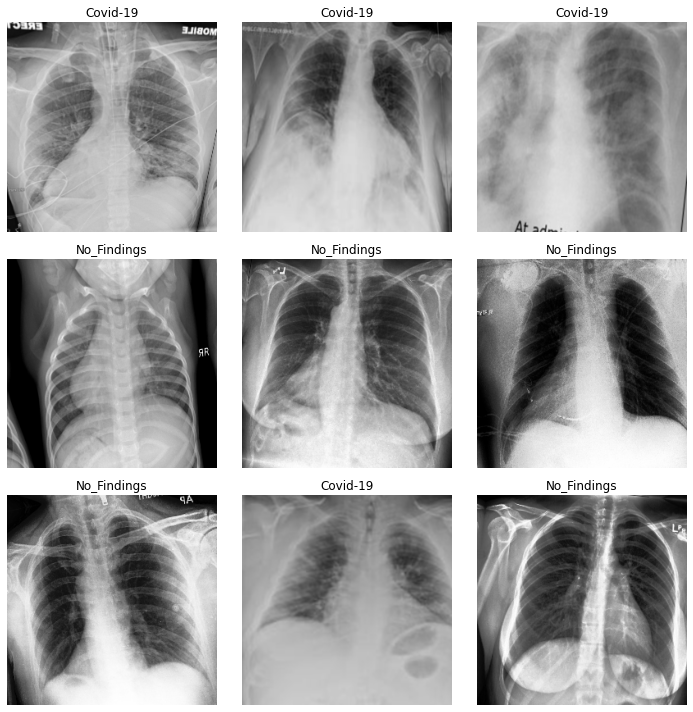

In [10]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [11]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False),
        nn.ReLU(nf),
        nn.BatchNorm2d(nf), 
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
           
    )

In [12]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [13]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [14]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    triple_conv(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [15]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [16]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
ReLU                 [8, 256, 256]        0          False     
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
ReLU                 [16, 128, 128]       0          False     
___________________________________________________

In [17]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.202439,0.113623,0.958510,06:30
1,0.136087,0.137639,0.950889,02:29
2,0.123669,0.244103,0.924640,02:29
3,0.108949,0.066286,0.978831,02:29
4,0.102869,0.138482,0.950042,02:29
5,0.091308,0.088488,0.966977,02:29
6,0.090272,0.127919,0.954276,02:29
7,0.091985,0.105519,0.955970,02:29
8,0.080494,0.071506,0.976291,02:29
9,0.098997,0.058351,0.983912,02:29


In [18]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 1181


In [19]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [20]:
accuracy(probs,targets)

tensor(0.9958)

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_Findings'], 2, 4720, 1181)

In [22]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

1181 1176 0.995766299745978
[[275   5]
 [  0 901]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.98      0.99       280
 No_findings       0.99      1.00      1.00       901

    accuracy                           1.00      1181
   macro avg       1.00      0.99      0.99      1181
weighted avg       1.00      1.00      1.00      1181



In [23]:
interp = ClassificationInterpretation.from_learner(learn)

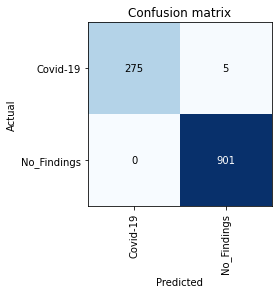

In [24]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);